In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow import keras

In [2]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")

In [3]:
train["file_path"] = train["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/test/" + identifier + ".jpg")

In [4]:
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 224
batch_size = 128
epochs = 100
train_on_fold = None # Which Fold to train, train on all folds if None
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

In [6]:
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image

In [7]:
def preprocess_training(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = data_augment(image)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

def preprocess_validation(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

In [8]:
def base_model():
    efficient_net = tf.keras.applications.EfficientNetB0(
        weights = "../input/efficientnet-b0-for-keras-no-top/efficientnetb0_notop.h5", 
        include_top = False, 
        input_shape = (image_size, image_size, 3)
    )    
    efficient_net.trainable = False
    return efficient_net

In [9]:
efficient_net = base_model()

2021-11-27 20:41:41.156975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 20:41:41.249702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 20:41:41.250451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 20:41:41.252109: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
def get_tabular_model(inputs):
    width = 32
    depth = 3
    activation = "relu"
    kernel_regularizer = keras.regularizers.l2()
    x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(inputs)
    for i in range(depth):
        if i == 0:
            x = inputs
        x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.Concatenate()([x, inputs])
    return x

In [11]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    image_x = efficient_net(image_inputs)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    #for _ in range(1):
    #    image_x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2())(image_x)
    image_x = tf.keras.layers.Dropout(0.5)(image_x)
    tabular_x = get_tabular_model(tabular_inputs)
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

In [12]:
show_architecture = False
if show_architecture:
    model = get_model()
    tf.keras.utils.plot_model(model, show_shapes=True)
    print(model.summary())
    image = np.random.normal(size=(1, image_size, image_size, 3))
    tabular = np.random.normal(size=(1, len(tabular_columns)))
    print(image.shape, tabular.shape)
    print(model((image, tabular)).shape)

Epoch 1/100


2021-11-27 20:41:51.448694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-27 20:42:02.053293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 442 of 512
2021-11-27 20:42:03.580519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-11-27 20:42:08.250103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


62/62 [==============================] - 201s 3s/step - loss: 1471.7719 - rmse: 38.3532 - val_loss: 1061.5311 - val_rmse: 32.5683


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 10s 167ms/step - loss: 592.6215 - rmse: 24.3248 - val_loss: 493.2774 - val_rmse: 22.1888
Epoch 3/100
62/62 [==============================] - 10s 169ms/step - loss: 463.5277 - rmse: 21.5083 - val_loss: 477.8451 - val_rmse: 21.8388
Epoch 4/100
62/62 [==============================] - 10s 168ms/step - loss: 450.1553 - rmse: 21.1955 - val_loss: 465.8846 - val_rmse: 21.5634
Epoch 5/100
62/62 [==============================] - 10s 168ms/step - loss: 438.8046 - rmse: 20.9260 - val_loss: 454.8522 - val_rmse: 21.3059
Epoch 6/100
62/62 [==============================] - 10s 168ms/step - loss: 426.4958 - rmse: 20.6295 - val_loss: 444.3406 - val_rmse: 21.0573
Epoch 7/100
62/62 [==============================] - 10s 168ms/step - loss: 415.3349 - rmse: 20.3567 - val_loss: 435.2314 - val_rmse: 20.8394
Epoch 8/100
62/62 [==============================] - 10s 169ms/step - loss: 407.8197 - rmse: 20.1706 - val_loss: 427.0073 - val_rmse: 20.6405
Epoch 

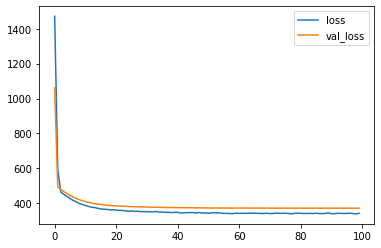

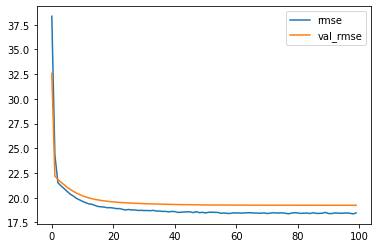

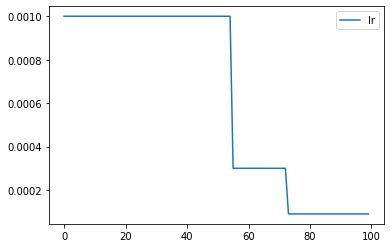

Epoch 1/100
62/62 [==============================] - 146s 2s/step - loss: 1482.5582 - rmse: 38.4937 - val_loss: 1038.9888 - val_rmse: 32.2210


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 10s 166ms/step - loss: 636.6530 - rmse: 25.2148 - val_loss: 469.9477 - val_rmse: 21.6578
Epoch 3/100
62/62 [==============================] - 10s 166ms/step - loss: 480.5008 - rmse: 21.9004 - val_loss: 454.4925 - val_rmse: 21.2984
Epoch 4/100
62/62 [==============================] - 10s 167ms/step - loss: 465.0637 - rmse: 21.5451 - val_loss: 439.0112 - val_rmse: 20.9315
Epoch 5/100
62/62 [==============================] - 11s 177ms/step - loss: 449.7234 - rmse: 21.1855 - val_loss: 424.6702 - val_rmse: 20.5851
Epoch 6/100
62/62 [==============================] - 10s 167ms/step - loss: 436.5116 - rmse: 20.8703 - val_loss: 411.9417 - val_rmse: 20.2724
Epoch 7/100
62/62 [==============================] - 10s 165ms/step - loss: 423.9289 - rmse: 20.5655 - val_loss: 401.6483 - val_rmse: 20.0158
Epoch 8/100
62/62 [==============================] - 10s 166ms/step - loss: 414.3933 - rmse: 20.3312 - val_loss: 393.3016 - val_rmse: 19.8052
Epoch 

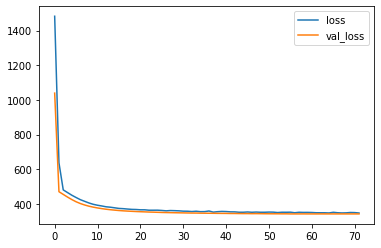

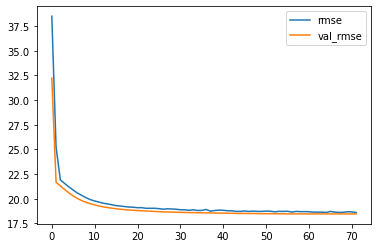

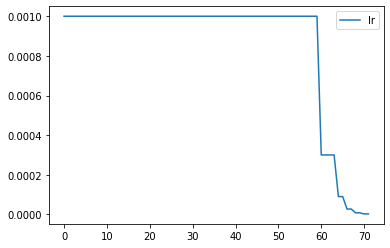

Epoch 1/100
62/62 [==============================] - 138s 2s/step - loss: 1486.4810 - rmse: 38.5449 - val_loss: 1169.8259 - val_rmse: 34.1917


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 10s 167ms/step - loss: 666.8445 - rmse: 25.8071 - val_loss: 483.3884 - val_rmse: 21.9664
Epoch 3/100
62/62 [==============================] - 10s 165ms/step - loss: 474.5245 - rmse: 21.7643 - val_loss: 465.3771 - val_rmse: 21.5535
Epoch 4/100
62/62 [==============================] - 10s 165ms/step - loss: 460.2735 - rmse: 21.4349 - val_loss: 450.0439 - val_rmse: 21.1950
Epoch 5/100
62/62 [==============================] - 10s 165ms/step - loss: 447.8308 - rmse: 21.1426 - val_loss: 436.5529 - val_rmse: 20.8740
Epoch 6/100
62/62 [==============================] - 10s 166ms/step - loss: 433.7035 - rmse: 20.8053 - val_loss: 424.0015 - val_rmse: 20.5705
Epoch 7/100
62/62 [==============================] - 10s 166ms/step - loss: 421.8921 - rmse: 20.5187 - val_loss: 413.4325 - val_rmse: 20.3110
Epoch 8/100
62/62 [==============================] - 10s 166ms/step - loss: 412.7099 - rmse: 20.2927 - val_loss: 404.0262 - val_rmse: 20.0771
Epoch 

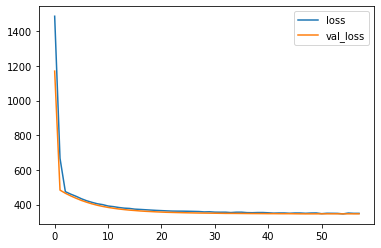

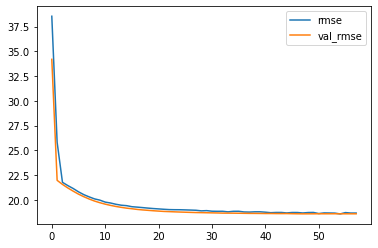

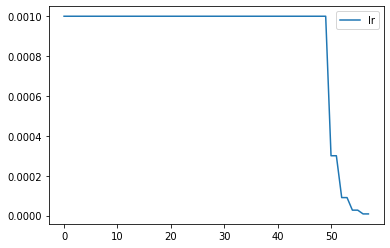

Epoch 1/100
62/62 [==============================] - 139s 2s/step - loss: 1495.2631 - rmse: 38.6584 - val_loss: 1104.9932 - val_rmse: 33.2293


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 10s 167ms/step - loss: 635.3585 - rmse: 25.1883 - val_loss: 495.7765 - val_rmse: 22.2450
Epoch 3/100
62/62 [==============================] - 10s 166ms/step - loss: 473.1305 - rmse: 21.7304 - val_loss: 475.8167 - val_rmse: 21.7923
Epoch 4/100
62/62 [==============================] - 10s 166ms/step - loss: 458.7327 - rmse: 21.3968 - val_loss: 461.4102 - val_rmse: 21.4593
Epoch 5/100
62/62 [==============================] - 10s 166ms/step - loss: 448.0209 - rmse: 21.1449 - val_loss: 448.7545 - val_rmse: 21.1621
Epoch 6/100
62/62 [==============================] - 10s 166ms/step - loss: 435.1483 - rmse: 20.8380 - val_loss: 437.3001 - val_rmse: 20.8892
Epoch 7/100
62/62 [==============================] - 10s 168ms/step - loss: 427.0565 - rmse: 20.6423 - val_loss: 426.6533 - val_rmse: 20.6321
Epoch 8/100
62/62 [==============================] - 10s 166ms/step - loss: 416.1313 - rmse: 20.3751 - val_loss: 417.0735 - val_rmse: 20.3978
Epoch 

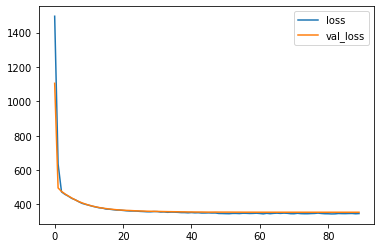

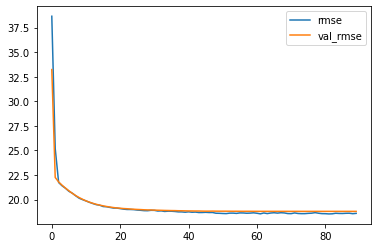

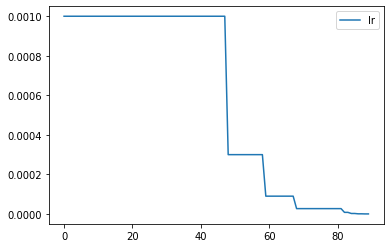

Epoch 1/100
62/62 [==============================] - 138s 2s/step - loss: 1531.8291 - rmse: 39.1289 - val_loss: 1114.6898 - val_rmse: 33.3753


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 10s 166ms/step - loss: 649.0114 - rmse: 25.4583 - val_loss: 478.0871 - val_rmse: 21.8441
Epoch 3/100
62/62 [==============================] - 10s 166ms/step - loss: 475.3824 - rmse: 21.7823 - val_loss: 457.9184 - val_rmse: 21.3779
Epoch 4/100
62/62 [==============================] - 10s 166ms/step - loss: 460.9794 - rmse: 21.4493 - val_loss: 442.6135 - val_rmse: 21.0168
Epoch 5/100
62/62 [==============================] - 10s 167ms/step - loss: 448.2056 - rmse: 21.1492 - val_loss: 430.6016 - val_rmse: 20.7288
Epoch 6/100
62/62 [==============================] - 10s 166ms/step - loss: 437.0872 - rmse: 20.8843 - val_loss: 419.5946 - val_rmse: 20.4611
Epoch 7/100
62/62 [==============================] - 10s 166ms/step - loss: 428.0037 - rmse: 20.6653 - val_loss: 410.4518 - val_rmse: 20.2360
Epoch 8/100
62/62 [==============================] - 10s 166ms/step - loss: 418.4433 - rmse: 20.4321 - val_loss: 402.3596 - val_rmse: 20.0345
Epoch 

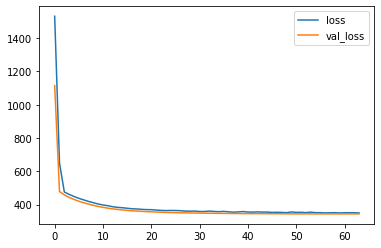

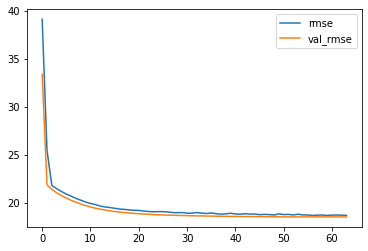

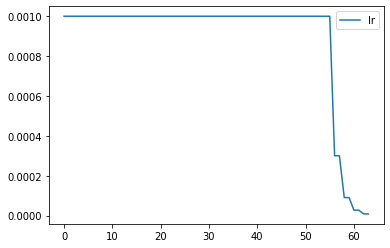

In [13]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_on_fold != None and train_on_fold != index:
        continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + tabular_columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + tabular_columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2, 
        min_lr=1e-7
    )
    callbacks = [early_stop, checkpoint, reduce_lr]
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess_training).shuffle(512).batch(batch_size).cache().prefetch(AUTO)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess_validation).batch(batch_size).cache().prefetch(AUTO)
    model = get_model()
    model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
    for metrics in [("loss", "val_loss"), ("rmse", "val_rmse"),["lr"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

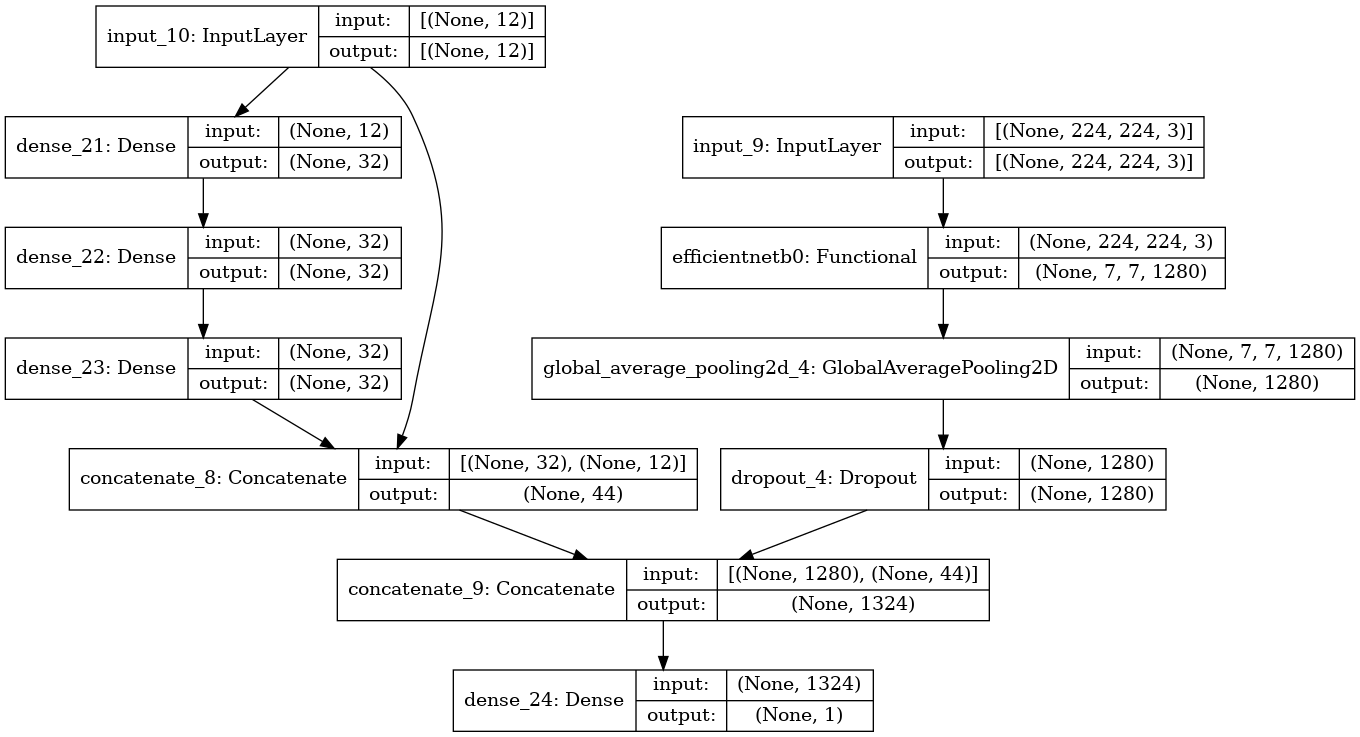

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [15]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [16]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [17]:
total_results = []
for model in models:
    total_results.append(model.predict(test_ds).reshape(-1))
results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)

In [18]:
sample_submission.head(5)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.379353
1,43a2262d7738e3d420d453815151079e,43.796013
2,4e429cead1848a298432a0acad014c9d,44.448669
3,80bc3ccafcc51b66303c2c263aa38486,35.834538
4,8f49844c382931444e68dffbe20228f4,34.711052
